In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import RobustScaler,PowerTransformer
from tqdm import tqdm
import lightgbm as lgb
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit


In [6]:
df = pd.read_csv("data/data-kiem-tra-2.csv")
df.head()

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,10.05.2013,4,58,3773,299.0,1
1,26.05.2013,4,58,3768,249.0,1
2,19.05.2013,4,58,4036,419.0,1
3,25.05.2013,4,58,12878,149.0,1
4,15.05.2013,4,58,12885,148.0,1


In [7]:
df.isnull().sum()

date        0
truong_1    0
truong_2    0
truong_3    0
truong_4    0
truong_5    0
dtype: int64

In [8]:
msv = 2151260835
msv%3 + 1

1

In [9]:
df.isnull().sum()

date        0
truong_1    0
truong_2    0
truong_3    0
truong_4    0
truong_5    0
dtype: int64

In [10]:
df.dtypes

date         object
truong_1      int64
truong_2      int64
truong_3      int64
truong_4    float64
truong_5      int64
dtype: object

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df.dtypes

date        datetime64[ns]
truong_1             int64
truong_2             int64
truong_3             int64
truong_4           float64
truong_5             int64
dtype: object

In [12]:
df = df.groupby('date').sum().reset_index()

In [13]:
df.set_index('date', inplace=True)

In [14]:
df.shape

(214, 5)

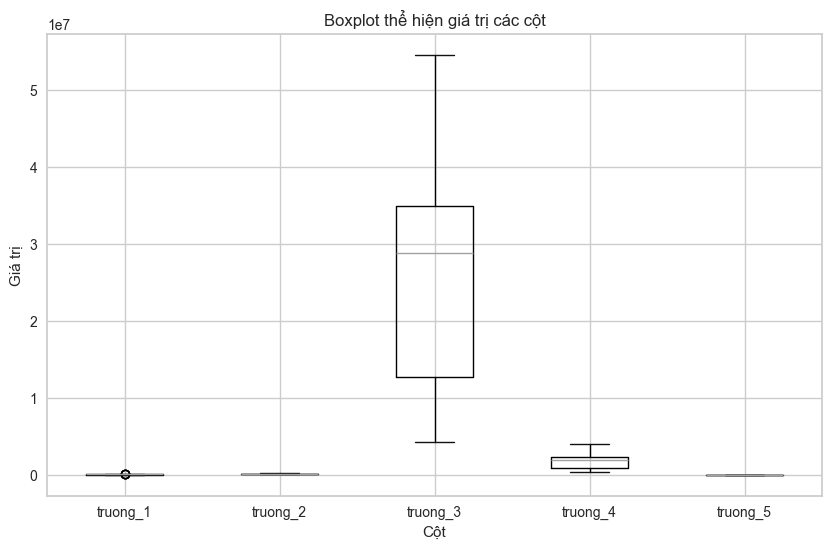

In [15]:
plt.figure(figsize=(10, 6))
df.boxplot()

# Thêm tiêu đề và nhãn trục
plt.title('Boxplot thể hiện giá trị các cột')
plt.ylabel('Giá trị')
plt.xlabel('Cột')
plt.show()

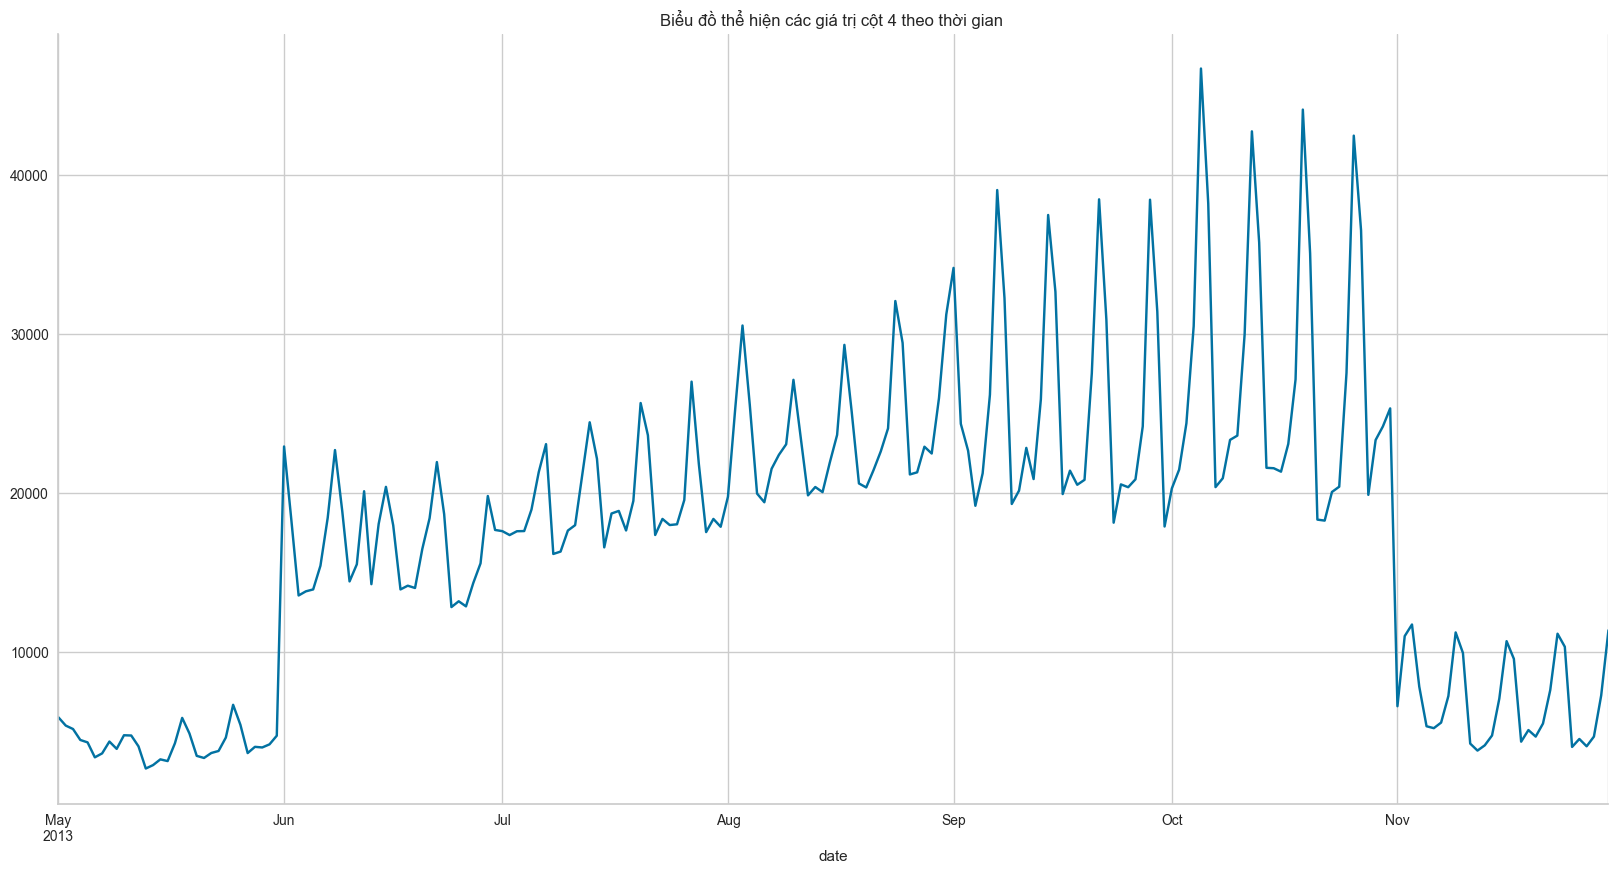

In [16]:
plt.figure(figsize=(20,10))
df['truong_1'].plot(kind='line',figsize=(20,10),title="Biểu đồ thể hiện các giá trị cột 4 theo thời gian ")
plt.gca().spines[['top','right']].set_visible(False)

# Hidden Markov

In [17]:
train_df = df[:-15]
test_df = df[-15:]
model_hmm = GaussianHMM(n_components=4, covariance_type="full", random_state=42)
model_hmm.fit(train_df['truong_1'].values.reshape(-1,1))

predicted_prices = []
current_price = train_df['truong_1'].values[-1]

for _ in range(len(test_df)):
    # Dự đoán trạng thái ẩn cho giá trị hiện tại
    current_state = model_hmm.predict([[current_price]])[0]
    # Lấy giá trị trung bình của trạng thái hiện tại để làm dự đoán cho bước tiếp theo
    predicted_price = np.random.normal(model_hmm.means_[current_state][0], np.sqrt(model_hmm.covars_[current_state][0][0]))
    predicted_prices.append(predicted_price)
    # Cập nhật giá trị hiện tại
    current_price = predicted_price
print(predicted_prices)

[4378.638431407578, 6397.9211678374295, 4757.086778127341, 9252.136620395184, 5789.658591706199, 4473.295828993214, 3356.2555825785053, 2203.7517976409267, 3949.311643671782, 7634.955902093324, 4858.280806325053, 6961.981336851537, 6211.529319402465, 4605.1799736260255, 3483.201255648838]


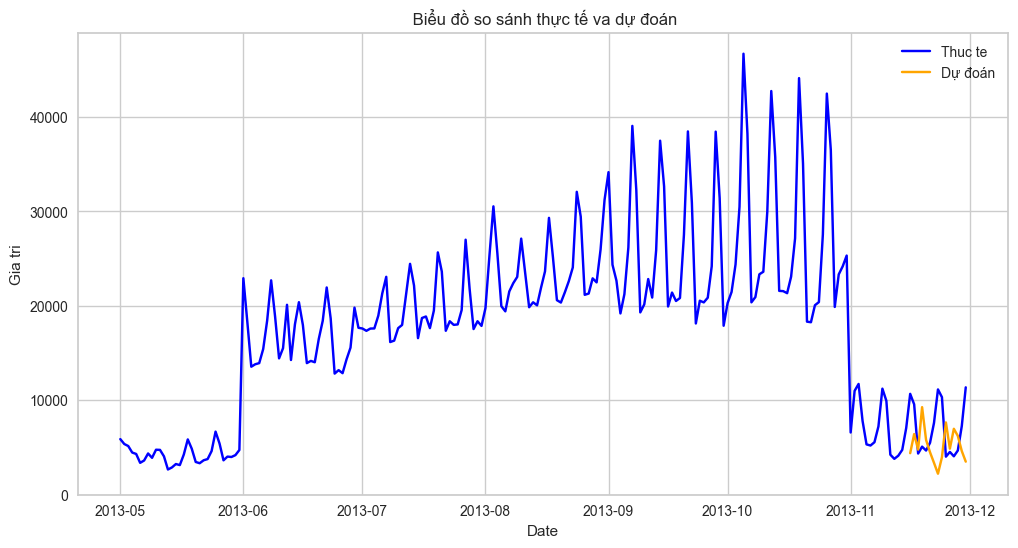

In [18]:
predicted_prices_df = pd.DataFrame(predicted_prices, index=test_df.index, columns=['predicted_sales'])

plt.figure(figsize=(12, 6))

plt.plot(df['truong_1'], label='Thuc te', color='blue')

plt.plot(predicted_prices_df['predicted_sales'], label='Dự đoán', color='orange')

plt.xlabel('Date')
plt.ylabel('Gia tri')
plt.title(' Biểu đồ so sánh thực tế va dự đoán')
plt.legend()
plt.show()

# LSTM

In [21]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Split data into training and testing
train_df = df[:-15]
test_df = df[-15:]

# Prepare training data
X_train = train_df['truong_1'].values.reshape(-1, 1)  # Reshape data for LSTM
y_train = train_df['truong_1'].values.reshape(-1, 1)  # Reshape data

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=32))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions on test data
X_test = test_df['truong_1'].values.reshape(-1, 1)
predictions = model.predict(X_test)

# Print the predicted prices
print(predictions)

Epoch 1/100


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 0s/step - loss: 441224832.0000 
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 400445312.0000 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 451409952.0000 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 410820352.0000 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 433533536.0000 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 397267040.0000 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 431839808.0000 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 435998240.0000 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 458212992.0000 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 430292224.0000 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 454795168.0000 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 431575680.0000 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 464867584.0000
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4

KeyError: 'predictions'

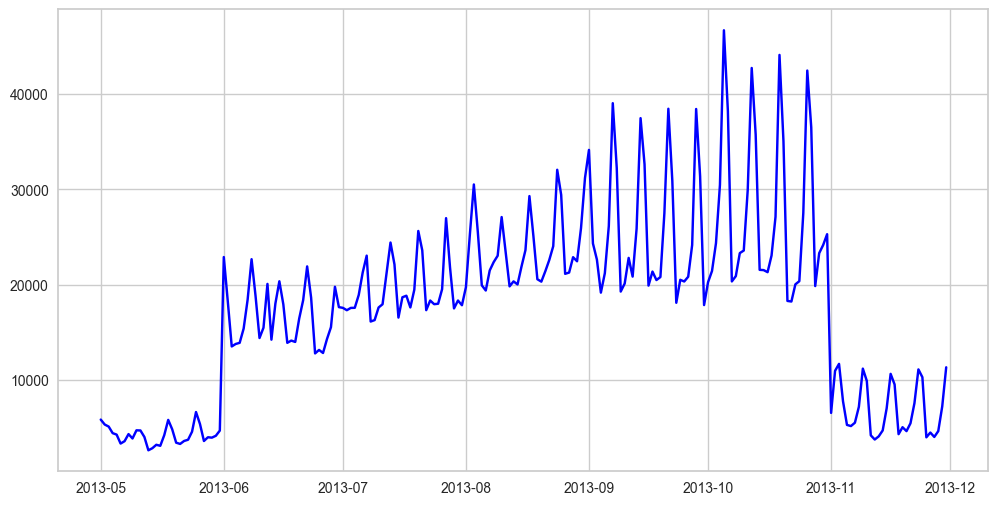

In [22]:
predictions_df = pd.DataFrame(predictions, index=test_df.index, columns=['predictions'])

plt.figure(figsize=(12, 6))

plt.plot(df['truong_1'], label='Thuc te', color='blue')

plt.plot(predicted_prices_df['predictions'], label='Dự đoán', color='orange')

plt.xlabel('Date')
plt.ylabel('Gia tri')
plt.title(' Biểu đồ so sánh thực tế va dự đoán')
plt.legend()
plt.show()